## Setup

Following libraries will be used for the task.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.14.4


In [ ]:
import json
import multiprocessing
import os
import re
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn


npx.set_np()

## Preparing the model

The original BERT model has hundreds of millions of parameters.
However, to be able to proceed with the training on Google Colaboratory environment, a pre-trained BERT model, provided by the d2l library, will be used.
Below, `bert.base` version is about as big as the original BERT base model that requires a lot of computational resources to fine-tune, while the `bert.small` version is a small version to facilitate demonstration.

The last line is the `SciTail` dataset which is the dataset used for the NLI task.


In [ ]:
SCITAIL_URL = 'http://data.allenai.org.s3.amazonaws.com/downloads/SciTailV1.1.zip'

d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.zip',
                              'a4e718a47137ccd1809c9107ab4f5edd317bae2c')
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.zip',
                             '7b3820b35da691042e5d34c0971ac3edbd80d3f4')
d2l.DATA_HUB['SciTail'] = (SCITAIL_URL,
                           '62000cc26e37b195b805d6fb245aff78ad29aaa3')

The download of the pre-trained model contains the vocabulary set and the parameters. These are loaded into the BERT model.

In [ ]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
  # Download
  data_dir = d2l.download_extract(pretrained_model)

  # Load the vocabulary set
  vocab = d2l.Vocab()
  vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
  vocab.token_to_idx = {token: idx for idx, token in enumerate(
      vocab.idx_to_token)}
  bert = d2l.BERTModel(len(vocab), num_hiddens, ffn_num_hiddens, num_heads, 
                        num_layers, dropout, max_len)
  
  # Load the parameters
  bert.load_parameters(os.path.join(data_dir, 'pretrained.params'),
                        ctx=devices)
  return bert, vocab

To achieve better results, the `bert.base` version will be used as the base BERT model. It will be kept in mind that, due to the limitation of Google Colaboratory environment, the batch size will be highly reduced and the training will take considerably longer.

In [ ]:
devices = d2l.try_all_gpus()
# bert, vocab = load_pretrained_model(
#     'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
#     num_layers=2, dropout=0.1, max_len=512, devices=devices)
bert, vocab = load_pretrained_model(
    'bert.base', num_hiddens=768, ffn_num_hiddens=3072, num_heads=12,
    num_layers=12, dropout=0.1, max_len=512, devices=devices)

## Preparing the dataset

To solve NLI tasks using BERT, the premise and the hypothesis of each example input need to be packed into single sequence. The premise tokens and the hypothesis tokens are separated using the special separation token. Tokens are also truncated if they exceed the given `max_len`.


In [ ]:
class NLIBERTDataset(gluon.data.Dataset):
  def __init__(self, dataset, max_len, vocab=None):
    all_pre mise_hypothesis_tokens = [[
        p_tokens, h_tokens] for p_tokens, h_tokens in zip(
        *[d2l.tokenize([s.lower() for s in sentences])
          for sentences in dataset[:2]])]
    
    self.labels = np.array(dataset[2])
    self.vocab = vocab
    self.max_len = max_len
    (self.all_token_ids, self.all_segments,
      self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
    print('read ' + str(len(self.all_token_ids)) + ' examples')

  def _preprocess(self, all_premise_hypothesis_tokens):
    # List IDs, segments and lengths
    all_token_ids = []
    all_segments = []
    valid_lens = []

    pool = multiprocessing.Pool(4)  # Use 4 worker processes
    out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
    for token_ids, segments, valid_len in out:
      all_token_ids.append(token_ids)
      all_segments.append(segments)
      valid_lens.append(valid_len)

    return (np.array(all_token_ids, dtype='int32'),
            np.array(all_segments, dtype='int32'), 
            np.array(valid_lens))

  def _mp_worker(self, premise_hypothesis_tokens):
    p_tokens, h_tokens = premise_hypothesis_tokens
    self._truncate_pair_of_tokens(p_tokens, h_tokens)
    tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)

    # Add padding to IDs and segments to fill `max_len`
    token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                          * (self.max_len - len(tokens))
    segments = segments + [0] * (self.max_len - len(segments))
    valid_len = len(tokens)
    return token_ids, segments, valid_len

  def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
    # Truncate and reserve for '<CLS>', '<SEP>', and '<SEP>' tokens
    while len(p_tokens) + len(h_tokens) > self.max_len - 3:
      if len(p_tokens) > len(h_tokens):
        p_tokens.pop()
      else:
        h_tokens.pop()

  def __getitem__(self, idx):
    return (self.all_token_ids[idx], self.all_segments[idx],
            self.valid_lens[idx]), self.labels[idx]

  def __len__(self):
    return len(self.all_token_ids)

The examples for training and testing will be generated used the above `NLIBERTDataset` class.


In [ ]:
def read_scitail(data_dir, is_train):
  # Load the SciTail dataset

  def _formatting(line):
    # Format json line
    row = json.loads(line)
    x_1 = row['sentence1']
    x_2 = row['sentence2']
    y = row['gold_label']
    return x_1, x_2, y

  def extract_text(s):
    # Remove information that will not be used by us
    s = re.sub('\\(', '', s) 
    s = re.sub('\\)', '', s)
    # Substitute two or more consecutive whitespace with space
    s = re.sub('\\s{2,}', ' ', s)
    return s.strip()
  
  label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
  file_name = os.path.join(data_dir, 'scitail_1.0_train.txt'
                            if is_train else 'scitail_1.0_test.txt')
  
  # Parse each line of dataset
  rows = []
  with open(file_name, 'r') as fp:
    for line in fp:
      try:
        x_1, x_2, y = _formatting(line)
        rows.append([y, x_1, x_2])
      except KeyError:
        continue
  
  # List premises, hypotheses and labels
  premises = []
  hypotheses = []
  labels = []
  for row in rows:
    if row[0] in label_set:
      premises.append(extract_text(row[1]))
      hypotheses.append(extract_text(row[2]))
      labels.append(label_set[row[0]])
  return premises, hypotheses, labels

In [ ]:
# Reduce `batch_size` if there is an out of memory error.
batch_size = 64
max_len = 128
num_workers = d2l.get_dataloader_workers()

data_dir = d2l.download_extract('SciTail')
data_dir = os.path.join(data_dir, 'snli_format')
train_set = NLIBERTDataset(read_scitail(data_dir, True), max_len, vocab)
test_set = NLIBERTDataset(read_scitail(data_dir, False), max_len, vocab)
train_iter = gluon.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = gluon.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 23596 examples
read 2126 examples


## Fine-tuning

To be able to fine-tune BERT model that has two sequences in a single input, two fully-connected layers (`self.hidden` and `self.output`) are used to transform the special `<cls>` token, that encodes information of both premise and hypothesis, into three outputs of the NLI task (entailment, contradiction and netural).


In [ ]:
class BERTClassifier(nn.Block):
  def __init__(self, bert):
    super(BERTClassifier, self).__init__()
    self.encoder = bert.encoder
    self.hidden = bert.hidden
    self.output = nn.Dense(3)

  def forward(self, inputs):
    tokens_X, segments_X, valid_lens_x = inputs
    encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
    return self.output(self.hidden(encoded_X[:, 0, :])) # <cls> token

The classifier model is instantiated. All the parameters of the pretrained BERT encoder (`net.encoder`) and the hidden layer of the additional MLP (net.hidden) will be fine-tuned.


In [ ]:
net = BERTClassifier(bert)
net.output.initialize(ctx=devices)

During fine-tuning, the parameters related to the language modelling should not be modified. The fine-tuning should only update the parameters relevant to the classification, the rest must not be updated (staled). The flag `ignore_stale_grad=True` is set to allow parameters with stale gradients.


loss 0.085, train acc 0.969, test acc 0.814
45.9 examples/sec on [gpu(0)]


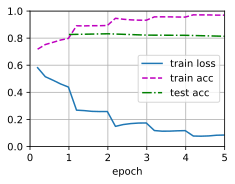

In [ ]:
lr, num_epochs = 1e-4, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices,
               d2l.split_batch_multi_inputs)